# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Tanh()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Tanh()
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 1)

# Loss Funktion; gibt Fehler an
loss_fn = nn.MSELoss()
#loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)

#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
            #print(pred.size())
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [8]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients

#         # Record the correct predictions for training data
#         _, predictions = torch.max(pred.data, 1)
#         train_correct += (predictions == y.data).sum()                
#         train_total += predictions.size(0)    

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping
    #train_loss.append(loss.item())
    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

#     loss = criterion(outputs, Variable(test_classes))
#     test_loss.append(loss.data[0])

Epoch 1/200, Iteration 1/25, Loss: 0.0078
Epoch 1/200, Iteration 2/25, Loss: 2.6950
Epoch 1/200, Iteration 3/25, Loss: 7.0915
Epoch 1/200, Iteration 4/25, Loss: 2.7849
Epoch 1/200, Iteration 5/25, Loss: 0.2380
Epoch 1/200, Iteration 6/25, Loss: 0.0593
Epoch 1/200, Iteration 7/25, Loss: 0.4231
Epoch 1/200, Iteration 8/25, Loss: 0.2510
Epoch 1/200, Iteration 9/25, Loss: 0.2721
Epoch 1/200, Iteration 10/25, Loss: 0.1970
Epoch 1/200, Iteration 11/25, Loss: 0.1980
Epoch 1/200, Iteration 12/25, Loss: 0.1966
Epoch 1/200, Iteration 13/25, Loss: 0.2521
Epoch 1/200, Iteration 14/25, Loss: 0.1387
Epoch 1/200, Iteration 15/25, Loss: 0.0275
Epoch 1/200, Iteration 16/25, Loss: 0.0635
Epoch 1/200, Iteration 17/25, Loss: 0.2111
Epoch 1/200, Iteration 18/25, Loss: 0.2403
Epoch 1/200, Iteration 19/25, Loss: 0.1653
Epoch 1/200, Iteration 20/25, Loss: 0.0475
Epoch 1/200, Iteration 21/25, Loss: 0.0391
Epoch 1/200, Iteration 22/25, Loss: 0.0553
Epoch 1/200, Iteration 23/25, Loss: 0.0357
Epoch 1/200, Iterati

Epoch 8/200, Iteration 1/25, Loss: 0.0017
Epoch 8/200, Iteration 2/25, Loss: 0.0063
Epoch 8/200, Iteration 3/25, Loss: 0.0041
Epoch 8/200, Iteration 4/25, Loss: 0.0030
Epoch 8/200, Iteration 5/25, Loss: 0.0056
Epoch 8/200, Iteration 6/25, Loss: 0.0013
Epoch 8/200, Iteration 7/25, Loss: 0.0065
Epoch 8/200, Iteration 8/25, Loss: 0.0031
Epoch 8/200, Iteration 9/25, Loss: 0.0032
Epoch 8/200, Iteration 10/25, Loss: 0.0061
Epoch 8/200, Iteration 11/25, Loss: 0.0008
Epoch 8/200, Iteration 12/25, Loss: 0.0078
Epoch 8/200, Iteration 13/25, Loss: 0.0037
Epoch 8/200, Iteration 14/25, Loss: 0.0049
Epoch 8/200, Iteration 15/25, Loss: 0.0075
Epoch 8/200, Iteration 16/25, Loss: 0.0021
Epoch 8/200, Iteration 17/25, Loss: 0.0082
Epoch 8/200, Iteration 18/25, Loss: 0.0006
Epoch 8/200, Iteration 19/25, Loss: 0.0047
Epoch 8/200, Iteration 20/25, Loss: 0.0044
Epoch 8/200, Iteration 21/25, Loss: 0.0060
Epoch 8/200, Iteration 22/25, Loss: 0.0083
Epoch 8/200, Iteration 23/25, Loss: 0.0039
Epoch 8/200, Iterati

Epoch 14/200, Iteration 22/25, Loss: 0.0014
Epoch 14/200, Iteration 23/25, Loss: 0.0071
Epoch 14/200, Iteration 24/25, Loss: 0.0017
Epoch 14/200, Iteration 25/25, Loss: 0.0055
Train Error: 
 Accuracy: 72.88%, Avg loss: 0.003213, MRE: 3.344828 

Test Error: 
 Accuracy: 77.5%, Avg loss: 0.003626, MRE: 8.560588 

Epoch 15/200, Iteration 1/25, Loss: 0.0032
Epoch 15/200, Iteration 2/25, Loss: 0.0092
Epoch 15/200, Iteration 3/25, Loss: 0.0054
Epoch 15/200, Iteration 4/25, Loss: 0.0056
Epoch 15/200, Iteration 5/25, Loss: 0.0022
Epoch 15/200, Iteration 6/25, Loss: 0.0075
Epoch 15/200, Iteration 7/25, Loss: 0.0013
Epoch 15/200, Iteration 8/25, Loss: 0.0051
Epoch 15/200, Iteration 9/25, Loss: 0.0014
Epoch 15/200, Iteration 10/25, Loss: 0.0052
Epoch 15/200, Iteration 11/25, Loss: 0.0021
Epoch 15/200, Iteration 12/25, Loss: 0.0087
Epoch 15/200, Iteration 13/25, Loss: 0.0011
Epoch 15/200, Iteration 14/25, Loss: 0.0075
Epoch 15/200, Iteration 15/25, Loss: 0.0023
Epoch 15/200, Iteration 16/25, Loss: 

Epoch 21/200, Iteration 17/25, Loss: 0.0026
Epoch 21/200, Iteration 18/25, Loss: 0.0065
Epoch 21/200, Iteration 19/25, Loss: 0.0009
Epoch 21/200, Iteration 20/25, Loss: 0.0044
Epoch 21/200, Iteration 21/25, Loss: 0.0022
Epoch 21/200, Iteration 22/25, Loss: 0.0065
Epoch 21/200, Iteration 23/25, Loss: 0.0014
Epoch 21/200, Iteration 24/25, Loss: 0.0043
Epoch 21/200, Iteration 25/25, Loss: 0.0010
Train Error: 
 Accuracy: 29.38%, Avg loss: 0.003637, MRE: 3.584162 

Test Error: 
 Accuracy: 23.0%, Avg loss: 0.003504, MRE: 7.204882 

Epoch 22/200, Iteration 1/25, Loss: 0.0067
Epoch 22/200, Iteration 2/25, Loss: 0.0065
Epoch 22/200, Iteration 3/25, Loss: 0.0013
Epoch 22/200, Iteration 4/25, Loss: 0.0052
Epoch 22/200, Iteration 5/25, Loss: 0.0010
Epoch 22/200, Iteration 6/25, Loss: 0.0010
Epoch 22/200, Iteration 7/25, Loss: 0.0015
Epoch 22/200, Iteration 8/25, Loss: 0.0022
Epoch 22/200, Iteration 9/25, Loss: 0.0010
Epoch 22/200, Iteration 10/25, Loss: 0.0015
Epoch 22/200, Iteration 11/25, Loss: 

Epoch 28/200, Iteration 12/25, Loss: 0.0019
Epoch 28/200, Iteration 13/25, Loss: 0.0032
Epoch 28/200, Iteration 14/25, Loss: 0.0030
Epoch 28/200, Iteration 15/25, Loss: 0.0019
Epoch 28/200, Iteration 16/25, Loss: 0.0092
Epoch 28/200, Iteration 17/25, Loss: 0.0120
Epoch 28/200, Iteration 18/25, Loss: 0.0074
Epoch 28/200, Iteration 19/25, Loss: 0.0165
Epoch 28/200, Iteration 20/25, Loss: 0.0051
Epoch 28/200, Iteration 21/25, Loss: 0.0176
Epoch 28/200, Iteration 22/25, Loss: 0.0048
Epoch 28/200, Iteration 23/25, Loss: 0.0110
Epoch 28/200, Iteration 24/25, Loss: 0.0168
Epoch 28/200, Iteration 25/25, Loss: 0.0279
Train Error: 
 Accuracy: 63.38%, Avg loss: 0.015067, MRE: 6.820020 

Test Error: 
 Accuracy: 68.5%, Avg loss: 0.013574, MRE: 19.063497 

Epoch 29/200, Iteration 1/25, Loss: 0.0208
Epoch 29/200, Iteration 2/25, Loss: 0.0459
Epoch 29/200, Iteration 3/25, Loss: 0.0096
Epoch 29/200, Iteration 4/25, Loss: 0.0258
Epoch 29/200, Iteration 5/25, Loss: 0.0257
Epoch 29/200, Iteration 6/25, Lo

Train Error: 
 Accuracy: 73.5%, Avg loss: 0.000378, MRE: 1.064188 

Test Error: 
 Accuracy: 77.0%, Avg loss: 0.000419, MRE: 2.783034 

Epoch 36/200, Iteration 1/25, Loss: 0.0006
Epoch 36/200, Iteration 2/25, Loss: 0.0005
Epoch 36/200, Iteration 3/25, Loss: 0.0014
Epoch 36/200, Iteration 4/25, Loss: 0.0005
Epoch 36/200, Iteration 5/25, Loss: 0.0003
Epoch 36/200, Iteration 6/25, Loss: 0.0005
Epoch 36/200, Iteration 7/25, Loss: 0.0004
Epoch 36/200, Iteration 8/25, Loss: 0.0009
Epoch 36/200, Iteration 9/25, Loss: 0.0003
Epoch 36/200, Iteration 10/25, Loss: 0.0003
Epoch 36/200, Iteration 11/25, Loss: 0.0007
Epoch 36/200, Iteration 12/25, Loss: 0.0004
Epoch 36/200, Iteration 13/25, Loss: 0.0004
Epoch 36/200, Iteration 14/25, Loss: 0.0003
Epoch 36/200, Iteration 15/25, Loss: 0.0006
Epoch 36/200, Iteration 16/25, Loss: 0.0004
Epoch 36/200, Iteration 17/25, Loss: 0.0004
Epoch 36/200, Iteration 18/25, Loss: 0.0007
Epoch 36/200, Iteration 19/25, Loss: 0.0011
Epoch 36/200, Iteration 20/25, Loss: 0

Epoch 42/200, Iteration 24/25, Loss: 0.0005
Epoch 42/200, Iteration 25/25, Loss: 0.0003
Train Error: 
 Accuracy: 77.25%, Avg loss: 0.000210, MRE: 0.735311 

Test Error: 
 Accuracy: 79.0%, Avg loss: 0.000257, MRE: 2.067140 

Epoch 43/200, Iteration 1/25, Loss: 0.0007
Epoch 43/200, Iteration 2/25, Loss: 0.0003
Epoch 43/200, Iteration 3/25, Loss: 0.0011
Epoch 43/200, Iteration 4/25, Loss: 0.0004
Epoch 43/200, Iteration 5/25, Loss: 0.0005
Epoch 43/200, Iteration 6/25, Loss: 0.0014
Epoch 43/200, Iteration 7/25, Loss: 0.0004
Epoch 43/200, Iteration 8/25, Loss: 0.0005
Epoch 43/200, Iteration 9/25, Loss: 0.0004
Epoch 43/200, Iteration 10/25, Loss: 0.0031
Epoch 43/200, Iteration 11/25, Loss: 0.0012
Epoch 43/200, Iteration 12/25, Loss: 0.0005
Epoch 43/200, Iteration 13/25, Loss: 0.0006
Epoch 43/200, Iteration 14/25, Loss: 0.0003
Epoch 43/200, Iteration 15/25, Loss: 0.0006
Epoch 43/200, Iteration 16/25, Loss: 0.0015
Epoch 43/200, Iteration 17/25, Loss: 0.0002
Epoch 43/200, Iteration 18/25, Loss: 

Epoch 49/200, Iteration 19/25, Loss: 0.0006
Epoch 49/200, Iteration 20/25, Loss: 0.0002
Epoch 49/200, Iteration 21/25, Loss: 0.0006
Epoch 49/200, Iteration 22/25, Loss: 0.0002
Epoch 49/200, Iteration 23/25, Loss: 0.0007
Epoch 49/200, Iteration 24/25, Loss: 0.0004
Epoch 49/200, Iteration 25/25, Loss: 0.0003
Train Error: 
 Accuracy: 74.88%, Avg loss: 0.000170, MRE: 0.649908 

Test Error: 
 Accuracy: 76.0%, Avg loss: 0.000218, MRE: 1.923600 

Epoch 50/200, Iteration 1/25, Loss: 0.0007
Epoch 50/200, Iteration 2/25, Loss: 0.0005
Epoch 50/200, Iteration 3/25, Loss: 0.0004
Epoch 50/200, Iteration 4/25, Loss: 0.0004
Epoch 50/200, Iteration 5/25, Loss: 0.0003
Epoch 50/200, Iteration 6/25, Loss: 0.0007
Epoch 50/200, Iteration 7/25, Loss: 0.0005
Epoch 50/200, Iteration 8/25, Loss: 0.0010
Epoch 50/200, Iteration 9/25, Loss: 0.0009
Epoch 50/200, Iteration 10/25, Loss: 0.0006
Epoch 50/200, Iteration 11/25, Loss: 0.0007
Epoch 50/200, Iteration 12/25, Loss: 0.0024
Epoch 50/200, Iteration 13/25, Loss: 

Epoch 56/200, Iteration 12/25, Loss: 0.0002
Epoch 56/200, Iteration 13/25, Loss: 0.0005
Epoch 56/200, Iteration 14/25, Loss: 0.0007
Epoch 56/200, Iteration 15/25, Loss: 0.0003
Epoch 56/200, Iteration 16/25, Loss: 0.0004
Epoch 56/200, Iteration 17/25, Loss: 0.0004
Epoch 56/200, Iteration 18/25, Loss: 0.0002
Epoch 56/200, Iteration 19/25, Loss: 0.0002
Epoch 56/200, Iteration 20/25, Loss: 0.0004
Epoch 56/200, Iteration 21/25, Loss: 0.0002
Epoch 56/200, Iteration 22/25, Loss: 0.0009
Epoch 56/200, Iteration 23/25, Loss: 0.0006
Epoch 56/200, Iteration 24/25, Loss: 0.0004
Epoch 56/200, Iteration 25/25, Loss: 0.0006
Train Error: 
 Accuracy: 89.62%, Avg loss: 0.000243, MRE: 0.697448 

Test Error: 
 Accuracy: 87.0%, Avg loss: 0.000325, MRE: 3.126617 

Epoch 57/200, Iteration 1/25, Loss: 0.0008
Epoch 57/200, Iteration 2/25, Loss: 0.0006
Epoch 57/200, Iteration 3/25, Loss: 0.0007
Epoch 57/200, Iteration 4/25, Loss: 0.0005
Epoch 57/200, Iteration 5/25, Loss: 0.0004
Epoch 57/200, Iteration 6/25, Los

Epoch 63/200, Iteration 4/25, Loss: 0.0005
Epoch 63/200, Iteration 5/25, Loss: 0.0006
Epoch 63/200, Iteration 6/25, Loss: 0.0010
Epoch 63/200, Iteration 7/25, Loss: 0.0002
Epoch 63/200, Iteration 8/25, Loss: 0.0003
Epoch 63/200, Iteration 9/25, Loss: 0.0004
Epoch 63/200, Iteration 10/25, Loss: 0.0010
Epoch 63/200, Iteration 11/25, Loss: 0.0007
Epoch 63/200, Iteration 12/25, Loss: 0.0002
Epoch 63/200, Iteration 13/25, Loss: 0.0004
Epoch 63/200, Iteration 14/25, Loss: 0.0003
Epoch 63/200, Iteration 15/25, Loss: 0.0006
Epoch 63/200, Iteration 16/25, Loss: 0.0005
Epoch 63/200, Iteration 17/25, Loss: 0.0002
Epoch 63/200, Iteration 18/25, Loss: 0.0002
Epoch 63/200, Iteration 19/25, Loss: 0.0005
Epoch 63/200, Iteration 20/25, Loss: 0.0004
Epoch 63/200, Iteration 21/25, Loss: 0.0014
Epoch 63/200, Iteration 22/25, Loss: 0.0002
Epoch 63/200, Iteration 23/25, Loss: 0.0009
Epoch 63/200, Iteration 24/25, Loss: 0.0010
Epoch 63/200, Iteration 25/25, Loss: 0.0034
Train Error: 
 Accuracy: 85.88%, Avg l

Train Error: 
 Accuracy: 72.75%, Avg loss: 0.000338, MRE: 1.164405 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.000327, MRE: 3.231508 

Epoch 70/200, Iteration 1/25, Loss: 0.0006
Epoch 70/200, Iteration 2/25, Loss: 0.0007
Epoch 70/200, Iteration 3/25, Loss: 0.0005
Epoch 70/200, Iteration 4/25, Loss: 0.0004
Epoch 70/200, Iteration 5/25, Loss: 0.0005
Epoch 70/200, Iteration 6/25, Loss: 0.0030
Epoch 70/200, Iteration 7/25, Loss: 0.0001
Epoch 70/200, Iteration 8/25, Loss: 0.0002
Epoch 70/200, Iteration 9/25, Loss: 0.0004
Epoch 70/200, Iteration 10/25, Loss: 0.0002
Epoch 70/200, Iteration 11/25, Loss: 0.0005
Epoch 70/200, Iteration 12/25, Loss: 0.0012
Epoch 70/200, Iteration 13/25, Loss: 0.0018
Epoch 70/200, Iteration 14/25, Loss: 0.0006
Epoch 70/200, Iteration 15/25, Loss: 0.0009
Epoch 70/200, Iteration 16/25, Loss: 0.0009
Epoch 70/200, Iteration 17/25, Loss: 0.0004
Epoch 70/200, Iteration 18/25, Loss: 0.0003
Epoch 70/200, Iteration 19/25, Loss: 0.0002
Epoch 70/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 91.38%, Avg loss: 0.000106, MRE: 0.541462 

Test Error: 
 Accuracy: 89.0%, Avg loss: 0.000131, MRE: 2.025343 

Epoch 77/200, Iteration 1/25, Loss: 0.0002
Epoch 77/200, Iteration 2/25, Loss: 0.0004
Epoch 77/200, Iteration 3/25, Loss: 0.0015
Epoch 77/200, Iteration 4/25, Loss: 0.0009
Epoch 77/200, Iteration 5/25, Loss: 0.0003
Epoch 77/200, Iteration 6/25, Loss: 0.0001
Epoch 77/200, Iteration 7/25, Loss: 0.0003
Epoch 77/200, Iteration 8/25, Loss: 0.0005
Epoch 77/200, Iteration 9/25, Loss: 0.0005
Epoch 77/200, Iteration 10/25, Loss: 0.0005
Epoch 77/200, Iteration 11/25, Loss: 0.0001
Epoch 77/200, Iteration 12/25, Loss: 0.0005
Epoch 77/200, Iteration 13/25, Loss: 0.0001
Epoch 77/200, Iteration 14/25, Loss: 0.0002
Epoch 77/200, Iteration 15/25, Loss: 0.0003
Epoch 77/200, Iteration 16/25, Loss: 0.0002
Epoch 77/200, Iteration 17/25, Loss: 0.0002
Epoch 77/200, Iteration 18/25, Loss: 0.0002
Epoch 77/200, Iteration 19/25, Loss: 0.0004
Epoch 77/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 78.88%, Avg loss: 0.000098, MRE: 0.482800 

Test Error: 
 Accuracy: 72.0%, Avg loss: 0.000128, MRE: 1.653192 

Epoch 84/200, Iteration 1/25, Loss: 0.0010
Epoch 84/200, Iteration 2/25, Loss: 0.0005
Epoch 84/200, Iteration 3/25, Loss: 0.0011
Epoch 84/200, Iteration 4/25, Loss: 0.0004
Epoch 84/200, Iteration 5/25, Loss: 0.0002
Epoch 84/200, Iteration 6/25, Loss: 0.0004
Epoch 84/200, Iteration 7/25, Loss: 0.0002
Epoch 84/200, Iteration 8/25, Loss: 0.0005
Epoch 84/200, Iteration 9/25, Loss: 0.0001
Epoch 84/200, Iteration 10/25, Loss: 0.0003
Epoch 84/200, Iteration 11/25, Loss: 0.0006
Epoch 84/200, Iteration 12/25, Loss: 0.0002
Epoch 84/200, Iteration 13/25, Loss: 0.0004
Epoch 84/200, Iteration 14/25, Loss: 0.0005
Epoch 84/200, Iteration 15/25, Loss: 0.0005
Epoch 84/200, Iteration 16/25, Loss: 0.0006
Epoch 84/200, Iteration 17/25, Loss: 0.0003
Epoch 84/200, Iteration 18/25, Loss: 0.0003
Epoch 84/200, Iteration 19/25, Loss: 0.0004
Epoch 84/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 62.0%, Avg loss: 0.000140, MRE: 0.578497 

Test Error: 
 Accuracy: 59.5%, Avg loss: 0.000178, MRE: 1.810491 

Epoch 91/200, Iteration 1/25, Loss: 0.0007
Epoch 91/200, Iteration 2/25, Loss: 0.0014
Epoch 91/200, Iteration 3/25, Loss: 0.0002
Epoch 91/200, Iteration 4/25, Loss: 0.0001
Epoch 91/200, Iteration 5/25, Loss: 0.0003
Epoch 91/200, Iteration 6/25, Loss: 0.0001
Epoch 91/200, Iteration 7/25, Loss: 0.0003
Epoch 91/200, Iteration 8/25, Loss: 0.0002
Epoch 91/200, Iteration 9/25, Loss: 0.0004
Epoch 91/200, Iteration 10/25, Loss: 0.0004
Epoch 91/200, Iteration 11/25, Loss: 0.0007
Epoch 91/200, Iteration 12/25, Loss: 0.0004
Epoch 91/200, Iteration 13/25, Loss: 0.0001
Epoch 91/200, Iteration 14/25, Loss: 0.0002
Epoch 91/200, Iteration 15/25, Loss: 0.0002
Epoch 91/200, Iteration 16/25, Loss: 0.0002
Epoch 91/200, Iteration 17/25, Loss: 0.0001
Epoch 91/200, Iteration 18/25, Loss: 0.0001
Epoch 91/200, Iteration 19/25, Loss: 0.0004
Epoch 91/200, Iteration 20/25, Loss: 0

Epoch 97/200, Iteration 22/25, Loss: 0.0009
Epoch 97/200, Iteration 23/25, Loss: 0.0002
Epoch 97/200, Iteration 24/25, Loss: 0.0016
Epoch 97/200, Iteration 25/25, Loss: 0.0003
Train Error: 
 Accuracy: 95.75%, Avg loss: 0.000119, MRE: 0.535373 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.000154, MRE: 2.288008 

Epoch 98/200, Iteration 1/25, Loss: 0.0009
Epoch 98/200, Iteration 2/25, Loss: 0.0003
Epoch 98/200, Iteration 3/25, Loss: 0.0006
Epoch 98/200, Iteration 4/25, Loss: 0.0001
Epoch 98/200, Iteration 5/25, Loss: 0.0002
Epoch 98/200, Iteration 6/25, Loss: 0.0001
Epoch 98/200, Iteration 7/25, Loss: 0.0003
Epoch 98/200, Iteration 8/25, Loss: 0.0003
Epoch 98/200, Iteration 9/25, Loss: 0.0002
Epoch 98/200, Iteration 10/25, Loss: 0.0002
Epoch 98/200, Iteration 11/25, Loss: 0.0003
Epoch 98/200, Iteration 12/25, Loss: 0.0003
Epoch 98/200, Iteration 13/25, Loss: 0.0002
Epoch 98/200, Iteration 14/25, Loss: 0.0007
Epoch 98/200, Iteration 15/25, Loss: 0.0019
Epoch 98/200, Iteration 16/25, Loss: 

Epoch 104/200, Iteration 23/25, Loss: 0.0001
Epoch 104/200, Iteration 24/25, Loss: 0.0004
Epoch 104/200, Iteration 25/25, Loss: 0.0004
Train Error: 
 Accuracy: 91.0%, Avg loss: 0.000087, MRE: 0.444360 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.000119, MRE: 2.088516 

Epoch 105/200, Iteration 1/25, Loss: 0.0003
Epoch 105/200, Iteration 2/25, Loss: 0.0010
Epoch 105/200, Iteration 3/25, Loss: 0.0002
Epoch 105/200, Iteration 4/25, Loss: 0.0003
Epoch 105/200, Iteration 5/25, Loss: 0.0006
Epoch 105/200, Iteration 6/25, Loss: 0.0003
Epoch 105/200, Iteration 7/25, Loss: 0.0002
Epoch 105/200, Iteration 8/25, Loss: 0.0002
Epoch 105/200, Iteration 9/25, Loss: 0.0004
Epoch 105/200, Iteration 10/25, Loss: 0.0001
Epoch 105/200, Iteration 11/25, Loss: 0.0002
Epoch 105/200, Iteration 12/25, Loss: 0.0003
Epoch 105/200, Iteration 13/25, Loss: 0.0004
Epoch 105/200, Iteration 14/25, Loss: 0.0002
Epoch 105/200, Iteration 15/25, Loss: 0.0003
Epoch 105/200, Iteration 16/25, Loss: 0.0005
Epoch 105/200, Iter

Epoch 112/200, Iteration 5/25, Loss: 0.0005
Epoch 112/200, Iteration 6/25, Loss: 0.0002
Epoch 112/200, Iteration 7/25, Loss: 0.0008
Epoch 112/200, Iteration 8/25, Loss: 0.0007
Epoch 112/200, Iteration 9/25, Loss: 0.0005
Epoch 112/200, Iteration 10/25, Loss: 0.0004
Epoch 112/200, Iteration 11/25, Loss: 0.0003
Epoch 112/200, Iteration 12/25, Loss: 0.0009
Epoch 112/200, Iteration 13/25, Loss: 0.0001
Epoch 112/200, Iteration 14/25, Loss: 0.0019
Epoch 112/200, Iteration 15/25, Loss: 0.0002
Epoch 112/200, Iteration 16/25, Loss: 0.0002
Epoch 112/200, Iteration 17/25, Loss: 0.0004
Epoch 112/200, Iteration 18/25, Loss: 0.0002
Epoch 112/200, Iteration 19/25, Loss: 0.0001
Epoch 112/200, Iteration 20/25, Loss: 0.0002
Epoch 112/200, Iteration 21/25, Loss: 0.0011
Epoch 112/200, Iteration 22/25, Loss: 0.0004
Epoch 112/200, Iteration 23/25, Loss: 0.0002
Epoch 112/200, Iteration 24/25, Loss: 0.0001
Epoch 112/200, Iteration 25/25, Loss: 0.0005
Train Error: 
 Accuracy: 94.75%, Avg loss: 0.000092, MRE: 0.

Train Error: 
 Accuracy: 68.62%, Avg loss: 0.000118, MRE: 0.541477 

Test Error: 
 Accuracy: 64.0%, Avg loss: 0.000148, MRE: 1.370120 

Epoch 119/200, Iteration 1/25, Loss: 0.0001
Epoch 119/200, Iteration 2/25, Loss: 0.0001
Epoch 119/200, Iteration 3/25, Loss: 0.0002
Epoch 119/200, Iteration 4/25, Loss: 0.0001
Epoch 119/200, Iteration 5/25, Loss: 0.0003
Epoch 119/200, Iteration 6/25, Loss: 0.0004
Epoch 119/200, Iteration 7/25, Loss: 0.0002
Epoch 119/200, Iteration 8/25, Loss: 0.0005
Epoch 119/200, Iteration 9/25, Loss: 0.0001
Epoch 119/200, Iteration 10/25, Loss: 0.0002
Epoch 119/200, Iteration 11/25, Loss: 0.0002
Epoch 119/200, Iteration 12/25, Loss: 0.0002
Epoch 119/200, Iteration 13/25, Loss: 0.0002
Epoch 119/200, Iteration 14/25, Loss: 0.0011
Epoch 119/200, Iteration 15/25, Loss: 0.0003
Epoch 119/200, Iteration 16/25, Loss: 0.0002
Epoch 119/200, Iteration 17/25, Loss: 0.0007
Epoch 119/200, Iteration 18/25, Loss: 0.0001
Epoch 119/200, Iteration 19/25, Loss: 0.0021
Epoch 119/200, Ite

Train Error: 
 Accuracy: 84.25%, Avg loss: 0.000087, MRE: 0.471901 

Test Error: 
 Accuracy: 80.0%, Avg loss: 0.000120, MRE: 1.829460 

Epoch 126/200, Iteration 1/25, Loss: 0.0003
Epoch 126/200, Iteration 2/25, Loss: 0.0002
Epoch 126/200, Iteration 3/25, Loss: 0.0001
Epoch 126/200, Iteration 4/25, Loss: 0.0006
Epoch 126/200, Iteration 5/25, Loss: 0.0004
Epoch 126/200, Iteration 6/25, Loss: 0.0002
Epoch 126/200, Iteration 7/25, Loss: 0.0012
Epoch 126/200, Iteration 8/25, Loss: 0.0023
Epoch 126/200, Iteration 9/25, Loss: 0.0007
Epoch 126/200, Iteration 10/25, Loss: 0.0007
Epoch 126/200, Iteration 11/25, Loss: 0.0001
Epoch 126/200, Iteration 12/25, Loss: 0.0004
Epoch 126/200, Iteration 13/25, Loss: 0.0002
Epoch 126/200, Iteration 14/25, Loss: 0.0002
Epoch 126/200, Iteration 15/25, Loss: 0.0004
Epoch 126/200, Iteration 16/25, Loss: 0.0003
Epoch 126/200, Iteration 17/25, Loss: 0.0015
Epoch 126/200, Iteration 18/25, Loss: 0.0002
Epoch 126/200, Iteration 19/25, Loss: 0.0002
Epoch 126/200, Ite

Train Error: 
 Accuracy: 95.75%, Avg loss: 0.000103, MRE: 0.486539 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.000138, MRE: 2.199356 

Epoch 133/200, Iteration 1/25, Loss: 0.0018
Epoch 133/200, Iteration 2/25, Loss: 0.0005
Epoch 133/200, Iteration 3/25, Loss: 0.0002
Epoch 133/200, Iteration 4/25, Loss: 0.0001
Epoch 133/200, Iteration 5/25, Loss: 0.0000
Epoch 133/200, Iteration 6/25, Loss: 0.0001
Epoch 133/200, Iteration 7/25, Loss: 0.0004
Epoch 133/200, Iteration 8/25, Loss: 0.0002
Epoch 133/200, Iteration 9/25, Loss: 0.0009
Epoch 133/200, Iteration 10/25, Loss: 0.0002
Epoch 133/200, Iteration 11/25, Loss: 0.0001
Epoch 133/200, Iteration 12/25, Loss: 0.0009
Epoch 133/200, Iteration 13/25, Loss: 0.0004
Epoch 133/200, Iteration 14/25, Loss: 0.0003
Epoch 133/200, Iteration 15/25, Loss: 0.0001
Epoch 133/200, Iteration 16/25, Loss: 0.0003
Epoch 133/200, Iteration 17/25, Loss: 0.0003
Epoch 133/200, Iteration 18/25, Loss: 0.0002
Epoch 133/200, Iteration 19/25, Loss: 0.0002
Epoch 133/200, Ite

Train Error: 
 Accuracy: 88.12%, Avg loss: 0.000086, MRE: 0.467484 

Test Error: 
 Accuracy: 86.0%, Avg loss: 0.000122, MRE: 2.084884 

Epoch 140/200, Iteration 1/25, Loss: 0.0013
Epoch 140/200, Iteration 2/25, Loss: 0.0023
Epoch 140/200, Iteration 3/25, Loss: 0.0004
Epoch 140/200, Iteration 4/25, Loss: 0.0002
Epoch 140/200, Iteration 5/25, Loss: 0.0001
Epoch 140/200, Iteration 6/25, Loss: 0.0003
Epoch 140/200, Iteration 7/25, Loss: 0.0004
Epoch 140/200, Iteration 8/25, Loss: 0.0002
Epoch 140/200, Iteration 9/25, Loss: 0.0011
Epoch 140/200, Iteration 10/25, Loss: 0.0018
Epoch 140/200, Iteration 11/25, Loss: 0.0001
Epoch 140/200, Iteration 12/25, Loss: 0.0009
Epoch 140/200, Iteration 13/25, Loss: 0.0003
Epoch 140/200, Iteration 14/25, Loss: 0.0004
Epoch 140/200, Iteration 15/25, Loss: 0.0002
Epoch 140/200, Iteration 16/25, Loss: 0.0001
Epoch 140/200, Iteration 17/25, Loss: 0.0002
Epoch 140/200, Iteration 18/25, Loss: 0.0001
Epoch 140/200, Iteration 19/25, Loss: 0.0001
Epoch 140/200, Ite

Train Error: 
 Accuracy: 88.5%, Avg loss: 0.000082, MRE: 0.462038 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.000109, MRE: 1.872327 

Epoch 148/200, Iteration 1/25, Loss: 0.0004
Epoch 148/200, Iteration 2/25, Loss: 0.0001
Epoch 148/200, Iteration 3/25, Loss: 0.0001
Epoch 148/200, Iteration 4/25, Loss: 0.0002
Epoch 148/200, Iteration 5/25, Loss: 0.0004
Epoch 148/200, Iteration 6/25, Loss: 0.0003
Epoch 148/200, Iteration 7/25, Loss: 0.0002
Epoch 148/200, Iteration 8/25, Loss: 0.0002
Epoch 148/200, Iteration 9/25, Loss: 0.0002
Epoch 148/200, Iteration 10/25, Loss: 0.0002
Epoch 148/200, Iteration 11/25, Loss: 0.0001
Epoch 148/200, Iteration 12/25, Loss: 0.0009
Epoch 148/200, Iteration 13/25, Loss: 0.0004
Epoch 148/200, Iteration 14/25, Loss: 0.0008
Epoch 148/200, Iteration 15/25, Loss: 0.0002
Epoch 148/200, Iteration 16/25, Loss: 0.0028
Epoch 148/200, Iteration 17/25, Loss: 0.0003
Epoch 148/200, Iteration 18/25, Loss: 0.0003
Epoch 148/200, Iteration 19/25, Loss: 0.0001
Epoch 148/200, Iter

Epoch 154/200, Iteration 20/25, Loss: 0.0003
Epoch 154/200, Iteration 21/25, Loss: 0.0001
Epoch 154/200, Iteration 22/25, Loss: 0.0001
Epoch 154/200, Iteration 23/25, Loss: 0.0002
Epoch 154/200, Iteration 24/25, Loss: 0.0001
Epoch 154/200, Iteration 25/25, Loss: 0.0004
Train Error: 
 Accuracy: 91.88%, Avg loss: 0.000085, MRE: 0.444443 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.000114, MRE: 1.967499 

Epoch 155/200, Iteration 1/25, Loss: 0.0001
Epoch 155/200, Iteration 2/25, Loss: 0.0001
Epoch 155/200, Iteration 3/25, Loss: 0.0010
Epoch 155/200, Iteration 4/25, Loss: 0.0002
Epoch 155/200, Iteration 5/25, Loss: 0.0004
Epoch 155/200, Iteration 6/25, Loss: 0.0003
Epoch 155/200, Iteration 7/25, Loss: 0.0009
Epoch 155/200, Iteration 8/25, Loss: 0.0002
Epoch 155/200, Iteration 9/25, Loss: 0.0003
Epoch 155/200, Iteration 10/25, Loss: 0.0001
Epoch 155/200, Iteration 11/25, Loss: 0.0002
Epoch 155/200, Iteration 12/25, Loss: 0.0003
Epoch 155/200, Iteration 13/25, Loss: 0.0003
Epoch 155/200, Ite

Train Error: 
 Accuracy: 86.5%, Avg loss: 0.000082, MRE: 0.468265 

Test Error: 
 Accuracy: 87.0%, Avg loss: 0.000106, MRE: 1.781909 

Epoch 162/200, Iteration 1/25, Loss: 0.0004
Epoch 162/200, Iteration 2/25, Loss: 0.0002
Epoch 162/200, Iteration 3/25, Loss: 0.0002
Epoch 162/200, Iteration 4/25, Loss: 0.0005
Epoch 162/200, Iteration 5/25, Loss: 0.0001
Epoch 162/200, Iteration 6/25, Loss: 0.0003
Epoch 162/200, Iteration 7/25, Loss: 0.0005
Epoch 162/200, Iteration 8/25, Loss: 0.0006
Epoch 162/200, Iteration 9/25, Loss: 0.0001
Epoch 162/200, Iteration 10/25, Loss: 0.0002
Epoch 162/200, Iteration 11/25, Loss: 0.0004
Epoch 162/200, Iteration 12/25, Loss: 0.0001
Epoch 162/200, Iteration 13/25, Loss: 0.0002
Epoch 162/200, Iteration 14/25, Loss: 0.0012
Epoch 162/200, Iteration 15/25, Loss: 0.0002
Epoch 162/200, Iteration 16/25, Loss: 0.0003
Epoch 162/200, Iteration 17/25, Loss: 0.0008
Epoch 162/200, Iteration 18/25, Loss: 0.0004
Epoch 162/200, Iteration 19/25, Loss: 0.0002
Epoch 162/200, Iter

Epoch 169/200, Iteration 16/25, Loss: 0.0002
Epoch 169/200, Iteration 17/25, Loss: 0.0002
Epoch 169/200, Iteration 18/25, Loss: 0.0004
Epoch 169/200, Iteration 19/25, Loss: 0.0002
Epoch 169/200, Iteration 20/25, Loss: 0.0001
Epoch 169/200, Iteration 21/25, Loss: 0.0009
Epoch 169/200, Iteration 22/25, Loss: 0.0007
Epoch 169/200, Iteration 23/25, Loss: 0.0001
Epoch 169/200, Iteration 24/25, Loss: 0.0002
Epoch 169/200, Iteration 25/25, Loss: 0.0003
Train Error: 
 Accuracy: 91.88%, Avg loss: 0.000087, MRE: 0.452375 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.000114, MRE: 2.014479 

Epoch 170/200, Iteration 1/25, Loss: 0.0009
Epoch 170/200, Iteration 2/25, Loss: 0.0002
Epoch 170/200, Iteration 3/25, Loss: 0.0006
Epoch 170/200, Iteration 4/25, Loss: 0.0003
Epoch 170/200, Iteration 5/25, Loss: 0.0004
Epoch 170/200, Iteration 6/25, Loss: 0.0005
Epoch 170/200, Iteration 7/25, Loss: 0.0005
Epoch 170/200, Iteration 8/25, Loss: 0.0003
Epoch 170/200, Iteration 9/25, Loss: 0.0002
Epoch 170/200, Ite

Train Error: 
 Accuracy: 89.38%, Avg loss: 0.000081, MRE: 0.421153 

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.000108, MRE: 1.739616 

Epoch 177/200, Iteration 1/25, Loss: 0.0001
Epoch 177/200, Iteration 2/25, Loss: 0.0004
Epoch 177/200, Iteration 3/25, Loss: 0.0003
Epoch 177/200, Iteration 4/25, Loss: 0.0001
Epoch 177/200, Iteration 5/25, Loss: 0.0001
Epoch 177/200, Iteration 6/25, Loss: 0.0002
Epoch 177/200, Iteration 7/25, Loss: 0.0001
Epoch 177/200, Iteration 8/25, Loss: 0.0003
Epoch 177/200, Iteration 9/25, Loss: 0.0009
Epoch 177/200, Iteration 10/25, Loss: 0.0005
Epoch 177/200, Iteration 11/25, Loss: 0.0001
Epoch 177/200, Iteration 12/25, Loss: 0.0002
Epoch 177/200, Iteration 13/25, Loss: 0.0002
Epoch 177/200, Iteration 14/25, Loss: 0.0005
Epoch 177/200, Iteration 15/25, Loss: 0.0002
Epoch 177/200, Iteration 16/25, Loss: 0.0005
Epoch 177/200, Iteration 17/25, Loss: 0.0002
Epoch 177/200, Iteration 18/25, Loss: 0.0004
Epoch 177/200, Iteration 19/25, Loss: 0.0003
Epoch 177/200, Ite

Epoch 184/200, Iteration 7/25, Loss: 0.0002
Epoch 184/200, Iteration 8/25, Loss: 0.0002
Epoch 184/200, Iteration 9/25, Loss: 0.0013
Epoch 184/200, Iteration 10/25, Loss: 0.0002
Epoch 184/200, Iteration 11/25, Loss: 0.0010
Epoch 184/200, Iteration 12/25, Loss: 0.0007
Epoch 184/200, Iteration 13/25, Loss: 0.0001
Epoch 184/200, Iteration 14/25, Loss: 0.0003
Epoch 184/200, Iteration 15/25, Loss: 0.0004
Epoch 184/200, Iteration 16/25, Loss: 0.0001
Epoch 184/200, Iteration 17/25, Loss: 0.0001
Epoch 184/200, Iteration 18/25, Loss: 0.0001
Epoch 184/200, Iteration 19/25, Loss: 0.0002
Epoch 184/200, Iteration 20/25, Loss: 0.0002
Epoch 184/200, Iteration 21/25, Loss: 0.0001
Epoch 184/200, Iteration 22/25, Loss: 0.0004
Epoch 184/200, Iteration 23/25, Loss: 0.0006
Epoch 184/200, Iteration 24/25, Loss: 0.0002
Epoch 184/200, Iteration 25/25, Loss: 0.0001
Train Error: 
 Accuracy: 77.12%, Avg loss: 0.000097, MRE: 0.517245 

Test Error: 
 Accuracy: 73.0%, Avg loss: 0.000123, MRE: 1.658527 

Epoch 185/20

Epoch 191/200, Iteration 10/25, Loss: 0.0002
Epoch 191/200, Iteration 11/25, Loss: 0.0003
Epoch 191/200, Iteration 12/25, Loss: 0.0001
Epoch 191/200, Iteration 13/25, Loss: 0.0001
Epoch 191/200, Iteration 14/25, Loss: 0.0001
Epoch 191/200, Iteration 15/25, Loss: 0.0001
Epoch 191/200, Iteration 16/25, Loss: 0.0001
Epoch 191/200, Iteration 17/25, Loss: 0.0002
Epoch 191/200, Iteration 18/25, Loss: 0.0003
Epoch 191/200, Iteration 19/25, Loss: 0.0001
Epoch 191/200, Iteration 20/25, Loss: 0.0004
Epoch 191/200, Iteration 21/25, Loss: 0.0003
Epoch 191/200, Iteration 22/25, Loss: 0.0002
Epoch 191/200, Iteration 23/25, Loss: 0.0011
Epoch 191/200, Iteration 24/25, Loss: 0.0002
Epoch 191/200, Iteration 25/25, Loss: 0.0003
Train Error: 
 Accuracy: 94.75%, Avg loss: 0.000095, MRE: 0.457843 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.000127, MRE: 2.170843 

Epoch 192/200, Iteration 1/25, Loss: 0.0003
Epoch 192/200, Iteration 2/25, Loss: 0.0001
Epoch 192/200, Iteration 3/25, Loss: 0.0001
Epoch 192/20

Epoch 198/200, Iteration 7/25, Loss: 0.0004
Epoch 198/200, Iteration 8/25, Loss: 0.0002
Epoch 198/200, Iteration 9/25, Loss: 0.0001
Epoch 198/200, Iteration 10/25, Loss: 0.0016
Epoch 198/200, Iteration 11/25, Loss: 0.0002
Epoch 198/200, Iteration 12/25, Loss: 0.0008
Epoch 198/200, Iteration 13/25, Loss: 0.0004
Epoch 198/200, Iteration 14/25, Loss: 0.0005
Epoch 198/200, Iteration 15/25, Loss: 0.0002
Epoch 198/200, Iteration 16/25, Loss: 0.0001
Epoch 198/200, Iteration 17/25, Loss: 0.0004
Epoch 198/200, Iteration 18/25, Loss: 0.0001
Epoch 198/200, Iteration 19/25, Loss: 0.0010
Epoch 198/200, Iteration 20/25, Loss: 0.0004
Epoch 198/200, Iteration 21/25, Loss: 0.0002
Epoch 198/200, Iteration 22/25, Loss: 0.0001
Epoch 198/200, Iteration 23/25, Loss: 0.0005
Epoch 198/200, Iteration 24/25, Loss: 0.0004
Epoch 198/200, Iteration 25/25, Loss: 0.0002
Train Error: 
 Accuracy: 89.75%, Avg loss: 0.000081, MRE: 0.437756 

Test Error: 
 Accuracy: 89.0%, Avg loss: 0.000112, MRE: 1.970337 

Epoch 199/20

#### Plots loss vs Iteration

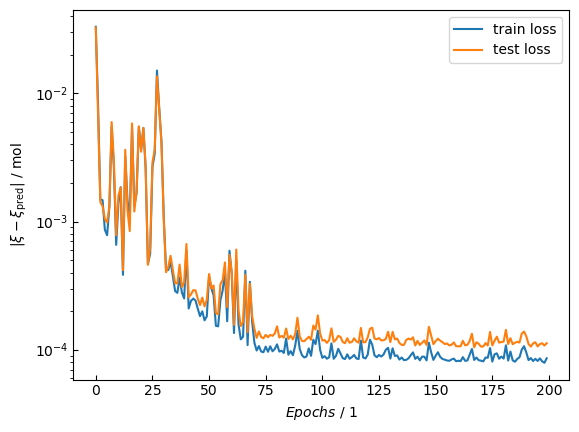

In [9]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
#plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.show()

#### Parity Plot

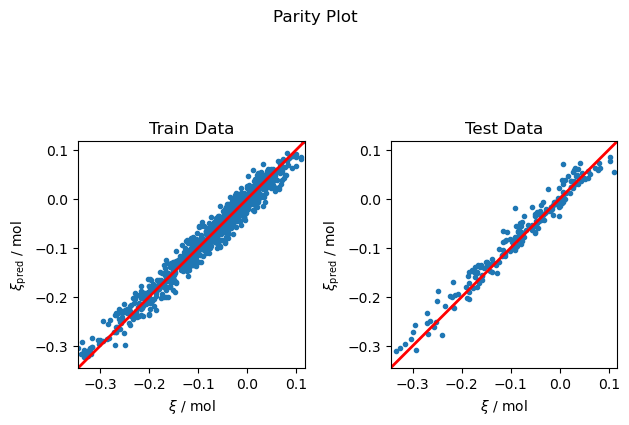

In [10]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2)

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].set_title('Train Data')

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].set_title('Test Data')


#plt.legend()
fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

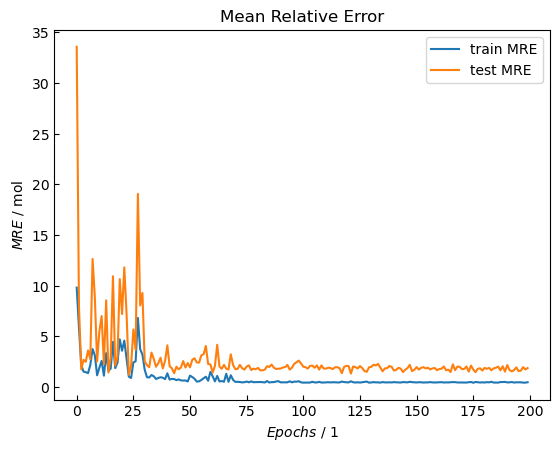

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.show()

#### Plot Loss vs Parameters

In [ ]:
mistake = []
param_T = []
param_p = []
param_x_H2 = []
param_x_N2 = []
param_x_NH3 = []
for X,y in train_dataloader:
    mistake = np.append(mistake, abs(y - net(X).detach().numpy()))
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2 = np.append(param_x_H2, X[:,2])
    param_x_N2 = np.append(param_x_N2, X[:,3])
    param_x_NH3 = np.append(param_x_NH3, X[:,4])
    
# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(1,3, figsize = (10, 5), gridspec_kw={'width_ratios': [2,2,3]})

ax[0].plot(param_T, mistake, '.', markersize = 2)
ax[0].set(xlabel = '$T$ / K', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)

ax[1].plot(param_p, mistake, '.', markersize = 2)
ax[1].set(xlabel = '$p$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)

ax[2].plot(param_x_H2, mistake, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[2].plot(param_x_N2, mistake, '.', markersize = 2, label = '$x\mathregular{_{N_2}}$')
ax[2].plot(param_x_NH3, mistake, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[2].set(xlabel = '$x\mathregular{_{NH_3}}$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[2].tick_params(direction = 'in') #, length = 20, width = 3)
ax[2].set

plt.legend()
plt.tight_layout()
plt.show()

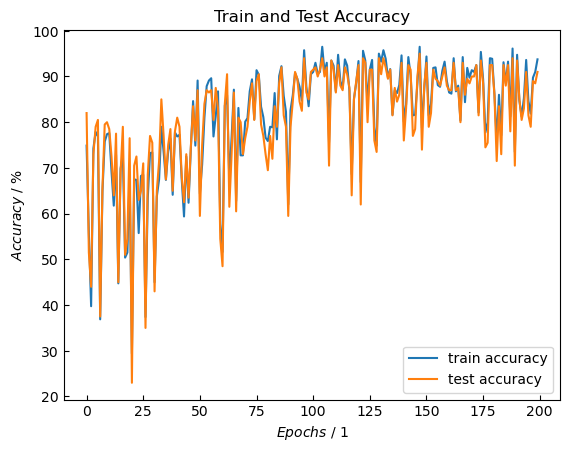

In [12]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.show()

#### Debugging Hilfe

In [13]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[8.2463e+02, 2.4564e+02, 3.8215e-01, 5.7636e-01, 4.1489e-02],
        [7.3862e+02, 1.2004e+02, 2.1548e-01, 7.6311e-01, 2.1411e-02],
        [6.5230e+02, 2.3509e+02, 1.7963e-01, 4.0606e-01, 4.1430e-01],
        [7.4615e+02, 2.1053e+02, 3.3816e-01, 5.0637e-01, 1.5547e-01],
        [7.5754e+02, 1.6601e+02, 6.5059e-01, 1.5692e-01, 1.9248e-01],
        [8.3569e+02, 1.4553e+02, 5.5183e-01, 3.5300e-01, 9.5170e-02],
        [7.8946e+02, 1.8358e+02, 3.6454e-01, 5.0449e-01, 1.3097e-01],
        [6.8796e+02, 1.2763e+02, 9.1934e-02, 7.4114e-01, 1.6693e-01],
        [7.2580e+02, 1.2171e+02, 5.1706e-01, 4.6251e-01, 2.0422e-02],
        [6.7348e+02, 2.4946e+02, 3.2166e-01, 1.4695e-01, 5.3139e-01],
        [7.2431e+02, 1.8509e+02, 2.6732e-01, 5.5092e-01, 1.8176e-01],
        [7.3619e+02, 1.2785e+02, 4.3246e-01, 3.8704e-01, 1.8050e-01],
        [7.4279e+02, 1.7102e+02, 3.1523e-01, 2.5765e-01, 4.2713e-01],
        [7.2450e+02, 1.1027e+02, 2.5043e-01, 5.8011e-01, 1.6946e-01],
        [7.7372e+02,

#### Einblick in Netzwerk

In [14]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([0.8937, 0.8443, 0.9247, 1.1003, 0.9394], requires_grad=True),
 Parameter containing:
 tensor([-0.0084, -0.0678,  0.0292, -0.0823,  0.0158], requires_grad=True),
 Parameter containing:
 tensor([[ 2.7661e-01,  3.8605e-01, -2.4601e-01,  2.3052e-01, -1.3069e-01],
         [ 2.6636e-01, -1.7746e-01, -4.8381e-01, -1.5762e-01, -1.3879e-01],
         [ 1.2975e-01,  9.3300e-02, -3.1455e-01,  4.2988e-01, -3.4574e-01],
         [-2.3162e-01, -1.0528e-01,  4.6176e-01,  3.8873e-01,  1.4230e-02],
         [-9.4656e-02, -2.3353e-01, -3.2070e-01, -3.0205e-02,  2.7350e-01],
         [ 1.3244e-01, -1.8551e-01, -5.5915e-01, -2.2547e-01, -1.6898e-01],
         [-8.7090e-02,  1.1961e-01,  3.0565e-01,  3.3506e-02,  2.1907e-01],
         [-3.0615e-02, -3.1539e-01,  3.2042e-01, -9.3735e-02,  2.3728e-01],
         [-3.4293e-01, -1.0433e-01,  1.0253e-01,  3.9928e-01,  7.6228e-02],
         [-1.8348e-02,  2.1622e-01, -1.9810e-01, -3.3778e-02, -4.1216e-01],
         [ 1.7894e-01, -

In [15]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.2486, 0.2025, 0.2406, 0.9543, 0.7324],
        [0.7979, 0.0325, 0.9934, 0.8008, 0.3661]])
tensor([[-0.1131],
        [-0.0568]], grad_fn=<AddmmBackward0>)


In [16]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [17]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    break

tensor([[8.3318e+02, 2.4344e+02, 3.6090e-02, 4.2346e-01, 5.4045e-01],
        [7.6859e+02, 1.1168e+02, 6.2213e-02, 2.6283e-01, 6.7495e-01],
        [7.8644e+02, 2.0125e+02, 3.0276e-01, 1.1570e-01, 5.8154e-01],
        [6.9770e+02, 2.4807e+02, 1.6104e-01, 6.3038e-01, 2.0857e-01],
        [6.9664e+02, 2.2653e+02, 9.5692e-02, 2.8072e-02, 8.7624e-01],
        [7.5289e+02, 2.1155e+02, 2.5790e-01, 4.3035e-01, 3.1174e-01],
        [6.9327e+02, 1.8414e+02, 3.5900e-01, 1.4118e-01, 4.9982e-01],
        [6.7711e+02, 1.3373e+02, 2.2936e-01, 4.6838e-04, 7.7017e-01],
        [7.6570e+02, 2.2547e+02, 6.2527e-02, 3.1743e-01, 6.2004e-01],
        [6.9470e+02, 1.1979e+02, 5.8874e-01, 2.3379e-01, 1.7747e-01],
        [8.1671e+02, 2.4731e+02, 1.7561e-01, 3.0300e-01, 5.2139e-01],
        [7.6440e+02, 1.6123e+02, 6.3620e-02, 6.8532e-01, 2.5106e-01],
        [6.9961e+02, 2.0997e+02, 2.6385e-02, 6.2347e-01, 3.5015e-01],
        [6.5924e+02, 1.7542e+02, 5.9980e-01, 3.2291e-01, 7.7288e-02],
        [7.4388e+02,